In [1]:
import numpy as np
from numpy.random import rand
import torch as th

from matplotlib import pyplot as plt
import matplotlib.patches as mp

import os

from datetime import date

import re

import json

In [2]:
# load patient and scan DBs

scan_db_fname  ="./PatientData/scan_database.json"
pat_db_fname   ="./PatientData/patient_database.json"

with open(scan_db_fname,"r") as f:
    scan_db=json.load(f)
    f.close()

with open(pat_db_fname,"r") as f:
    patient_db=json.load(f)
    f.close()

# load file mapping to split number
split_map_fname="./PatientData/split_map.json"

with open(split_map_fname,"r") as f:
    split_map=json.load(f)
    f.close()

In [3]:
# load predictions
    
# for testing on synthetic data, as instructed by the README:
result_files={
    1:"./result_v0_syntDataCheck/log_split_1/output_last.npy",
}

# result_files={
#     0:"./results/result_v645/result_split_0.npy",
#     1:"./results/result_v645/result_split_1.npy",
#     2:"./results/result_v645/result_split_2.npy",
#     3:"./results/result_v645/result_split_3.npy",
#     4:"./results/result_v645/result_split_4.npy",
# }

result_in_split={}
for splitnum,fname in result_files.items():

    result=np.load(fname,allow_pickle=True).item()

    # check the result
    assert result["split"]==splitnum
    for scanfname in result["prediction"].keys():
        pat=scan_db[scanfname]["patient"]
        assert split_map[pat]==splitnum
    
    result_in_split[splitnum]=result["prediction"]

In [4]:
# functions for selecting the predictions for the analysis

def select_predictions_(result,condition):
    res={}
    for k,v in result.items():
        if condition(k):
            res[k]=v
    return res
    
def select_predictions(result_per_split,condition):
    res_per_split={}
    for splitnum,result in result_per_split.items():
        res_per_split[splitnum]=select_predictions_(result,condition)
    return res_per_split

def condition_after_onset(fname):
# scan comes either from a non-BOS patient
#            or     from a     BOS patient and was taken after the disease onset
    p=scan_db[fname]["patient"]
    if patient_db[p]["label"]==0:
        return True
    
    onset_date=date(**patient_db[p]["FEV1_level_dates"]['0.8'])
    scan_date =date(**scan_db[fname]["date"])
    return scan_date>onset_date

def condition_stage_I(fname):
# scan comes either from a non-BOS patient
#            or     from a     BOS patient and was taken for FEV1 range 0.8-0.65 of the best value
    p=scan_db[fname]["patient"]
    if patient_db[p]["label"]==0:
        return True
    
    scan_date =date(**scan_db[fname]["date"])
    fev1_dict=patient_db[p]["FEV1_level_dates"]
    
    date_080=date(**fev1_dict['0.8'])
    if scan_date<=date_080:
        return False
    
    # '0.65' not in dict means lower values were never observed
    if '0.65' not in fev1_dict:
        return True
    
    date_065=date(**fev1_dict['0.65'])
    return  date_065>=scan_date

def condition_stage_II(fname):
# scan comes either from a non-BOS patient
#            or     from a     BOS patient and was taken for FEV1 range 0.65-0.5 of the best value
    p=scan_db[fname]["patient"]
    if patient_db[p]["label"]==0:
        return True
    
    scan_date =date(**scan_db[fname]["date"])
    fev1_dict=patient_db[p]["FEV1_level_dates"]
    
    if '0.65' not in fev1_dict:
        return False
    date_065=date(**fev1_dict['0.65'])
    if scan_date<=date_065:
        return False
    
    if '0.5' not in fev1_dict:
        return True
    date_050=date(**fev1_dict['0.5'])
    return  date_050>=scan_date

def condition_stage_III(fname):
# scan comes either from a non-BOS patient
#            or     from a     BOS patient and was taken for FEV1 range <=0.5 of the best value
    p=scan_db[fname]["patient"]
    if patient_db[p]["label"]==0:
        return True
    
    scan_date =date(**scan_db[fname]["date"])
    fev1_dict=patient_db[p]["FEV1_level_dates"]
    
    if '0.5' not in fev1_dict:
        return False
    date_050=date(**fev1_dict['0.5'])
    return  scan_date>date_050



In [5]:
# weight definition for plotting the ROC and computing the AUC
# weights are defined in such a way that each patient contributes the same
# irrespectively of the number of visits to radiology, or scan copies for a visit

def get_weights_(result):
    patdict={}
    for f in result.keys():
        pat  =       scan_db[f]["patient"]
        dat  =date(**scan_db[f]["date"])
        if pat not in patdict:
            patdict[pat]={dat:1}
        else:
            if dat not in patdict[pat]:
                patdict[pat][dat]=1
            else:
                patdict[pat][dat]=patdict[pat][dat]+1
    weightdict={}
    for f in result.keys():
        pat=       scan_db[f]["patient"]
        dat=date(**scan_db[f]["date"])
        patweight =1.0/len(patdict[pat])
        dateweight=1.0/patdict[pat][dat]
        weightdict[f]=patweight *dateweight
#         weightdict[f]=1.0
    
    return weightdict

def get_weights(result_per_split):
    weights={}
    for splitnum,result in result_per_split.items():
        weights.update(get_weights_(result))
    return weights


In [6]:
# ROC plotting functions

from rocAuc import FprTprAucFromPredLists_Weighted

def check_metadata(f):
    return True

def get_roc(res_dict,weight_dict,scan_db,patient_db):
    
    bos_preds=[(t.item(),weight_dict[f]) for f,t in res_dict.items() if patient_db[scan_db[f]["patient"]]["label"]==1 ]
    nor_preds=[(t.item(),weight_dict[f]) for f,t in res_dict.items() if patient_db[scan_db[f]["patient"]]["label"]==0 ]
    
    fpr,tpr,auc_weighted=FprTprAucFromPredLists_Weighted(nor_preds,bos_preds)
    
    return fpr,tpr,auc_weighted

def get_roc_split(res_dict_per_split,weight_dict,scan_db,patient_db):
    
    roc_split={}
    for splitnum,res_dict in res_dict_per_split.items():
        # produce split results only if both positive and negative samples present in test subset
        numpos=sum([  patient_db[scan_db[f]["patient"]]["label"] for f in res_dict.keys()])       
        numneg=sum([1-patient_db[scan_db[f]["patient"]]["label"] for f in res_dict.keys()])
        if numpos>0 and numneg>0:
            fpr,tpr,wauc=get_roc(res_dict,weight_dict,scan_db,patient_db)
            roc_split[splitnum]={"auc":wauc,
                                 "fpr":fpr,
                                 "tpr":tpr,
                                }
    return roc_split

def get_roc_accumulated(res_dict_per_split,weight_dict,scan_db,patient_db):

    res_dict_cummulated={}
    for splitnum,res_dict in res_dict_per_split.items():
        res_dict_cummulated.update(res_dict)
        
    fpr,tpr,wauc=get_roc(res_dict_cummulated,weight_dict,scan_db,patient_db)
    
    return fpr,tpr,wauc

def plot_split_roc(res_dict_per_split,weight_dict,scan_db,patient_db):
    # res_dicts is a dictionary of dictionaries: {split_number:result_dict}
        
    aucs={}
    for splitnum,res_dict in res_dict_per_split.items():
        fpr,tpr,wauc=get_roc(res_dict,weight_dict,scan_db,patient_db)
        plt.plot(fpr,tpr,label="split "+str(splitnum),color=color,linestyle=linestyle or "-")
        aucs[splitnum]=wauc
            
    return aucs
        
def plot_cumulated_roc(res_dict_per_split,weight_dict,scan_db,patient_db,color=None,linestyle=None,
                       label="accumulated"):
    
    res_dict_cummulated={}
    for splitnum,res_dict in res_dict_per_split.items():
        res_dict_cummulated.update(res_dict)
        
    fpr,tpr,wauc=get_roc(res_dict_cummulated,weight_dict,scan_db,patient_db)
    plt.plot(fpr,tpr,label=label,color=color,linestyle=linestyle or "-")
    
    return wauc


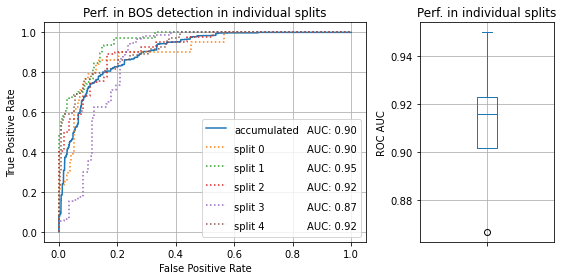

In [7]:
# plot results in BOS vs non-BOS recognition

sel_res_in_split=select_predictions(result_in_split,condition_after_onset)
weights=get_weights(sel_res_in_split)

f=plt.figure(figsize=(10.5,4))

# left part of the plot
plt.subplot(1,4,(1,2))

fpr_acc,tpr_acc,auc_acc  =get_roc_accumulated(sel_res_in_split,weights,scan_db,patient_db)
plt.plot(fpr_acc,tpr_acc,label="accumulated")

roc_split=get_roc_split(sel_res_in_split,weights,scan_db,patient_db)
aucs=[auc_acc,]
for splitnum,roc in roc_split.items():
    plt.plot(roc["fpr"],roc["tpr"],label="split "+str(splitnum),linestyle=":")
    aucs.append(roc["auc"])

# make the AUCs align vertically in the legend
handles, labels = plt.gca().get_legend_handles_labels() # get existing handles and labels
for a in aucs:
    l="AUC: {:.2f}".format(a)
    empty_patch = mp.Patch(color='none',label="") # create a patch with no color
    handles.append(empty_patch)                   # add new patches and labels to list
    labels .append(l)
lgnd=plt.legend(handles,labels,ncol=2,columnspacing=-2,handleheight=1.8)

plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Perf. in BOS detection in individual splits")

# right part of the plot
plt.subplot(1,4,3)

bp=plt.boxplot([roc["auc"] for roc in roc_split.values()],labels=["",],positions=[0,])

# set boxplot color and style
for element in ['boxes', 'whiskers', 'fliers', ]:
    plt.setp(bp[element], linestyle='-')
for element in ['boxes', 'whiskers', 'fliers', 'caps','medians']:
    plt.setp(bp[element], color='C0')

plt.ylabel("ROC AUC")
plt.xticks(rotation=0)
plt.title("Perf. in individual splits")
plt.grid()

plt.tight_layout()
#plt.savefig("results_per_split.pdf")
plt.show()

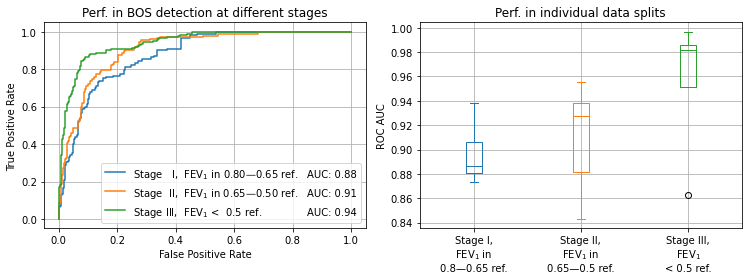

In [8]:
# plot results in differentiating BOS-stage <I,II,III> scans from non-BOS scans 

roc_per_split  ={}
roc_accumulated={}
for label,condition in zip([         "stage I",        "stage II",        "stage III"],
                           [condition_stage_I,condition_stage_II,condition_stage_III]):
    sel_res_in_split=select_predictions(result_in_split,condition)
    weights=get_weights(sel_res_in_split)
    fpr_acc,tpr_acc,auc_acc  =get_roc_accumulated(sel_res_in_split,weights,scan_db,patient_db)
    roc_accumulated[label]={"fpr":fpr_acc,
                            "tpr":tpr_acc,
                            "auc":auc_acc,
                           }
    roc_split=get_roc_split(sel_res_in_split,weights,scan_db,patient_db)
    roc_per_split[label]=roc_split
    
colors={
    "stage I"  :'C0',
    "stage II" :'C1',
    "stage III":'C2',
}
f=plt.figure(figsize=(10.5,4))

# left part of the plot
plt.subplot(1,2,1)
    
labels={
    "stage I"  :"Stage   I,  FEV$_1$ in 0.80{}0.65 ref.".format(u"\u2014"),
    "stage II" :"Stage  II,  FEV$_1$ in 0.65{}0.50 ref.".format(u"\u2014"),
    "stage III":"Stage III,  FEV$_1$ <  0.5 ref.",
}

aucs=[]
for name,roc in roc_accumulated.items():
    plt.plot(roc["fpr"],roc["tpr"],label=labels[name],color=colors[name])
    aucs.append(roc["auc"])

# make the AUCs align vertically in the legend
handles, labels = plt.gca().get_legend_handles_labels() # get existing handles and labels
for auc in aucs:
    l="AUC: {:.2f}".format(auc)
    empty_patch = mp.Patch(color='none',label="") # create a patch with no color
    handles.append(empty_patch)                   # add new patches and labels to list
    labels .append(l)
lgnd=plt.legend(handles,labels,ncol=2,columnspacing=-2,handleheight=1.8)

plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Perf. in BOS detection at different stages")

# right part of the plot
plt.subplot(1,2,2)

labels={
    "stage I"  :"Stage I,\nFEV$_1$ in\n0.8{}0.65 ref.".format(u"\u2014"),
    "stage II" :"Stage II,\nFEV$_1$ in\n0.65{}0.5 ref.".format(u"\u2014"),
    "stage III":"Stage III,\nFEV$_1$\n< 0.5 ref.",
}

for i,(name,roc_split) in  enumerate(roc_per_split.items()):
    bp=plt.boxplot([roc["auc"] for roc in roc_split.values() ],labels=[labels[name],],positions=[i,])

    # set boxplot color and style
    for element in ['boxes', 'whiskers', 'fliers', ]:
        plt.setp(bp[element], linestyle='-')
    for element in ['boxes', 'whiskers', 'fliers', 'caps','medians']:
        plt.setp(bp[element], color=colors[name])

plt.ylabel("ROC AUC")
plt.xticks(rotation=0)
plt.title("Perf. in individual data splits")
plt.grid()

plt.tight_layout()
#plt.savefig("results_per_BOS_stage.pdf")
plt.show()

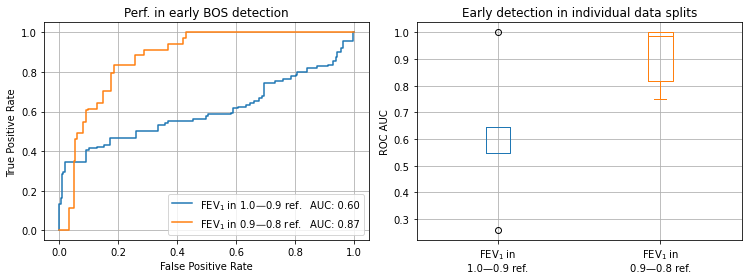

In [9]:
# plot early detection results

# the other evaluations are based on "stage onset" dates where patient's relative FEV1
# drops below a threshold on at least two consecutive tests taken at least three weeks apart
# the relative FEV1 = FEV1 expressed as a percentage of the average between two best values
#                     attained at least two weeks apart

# this evaluation uses scans with FEV1 measurement taken within 30 days from the scan acquisition
# relative FEV1 is computed as the ratio of the current measurement to the average of two best values
# attained at least two weeks apart and before the current measurement
# the intention is to mimick a clinical scenario where a FEV1 drop below 90% of best value
# is observed in a patient that presents themselves for a periodic evaluation

# load FEV1 measurement for the scans for which it is available
# (a scan was included if a PFT was performed within 30 days)
with open("./PatientData/scan2RelFev1.json","r") as f:
    scan2relfev1=json.load(f)
    f.close()

def condition_relFev1_10_09(fname):

    if fname not in scan2relfev1:
        return False
    
    return scan2relfev1[fname]>=0.9 and scan2relfev1[fname]<=1.0

def condition_relFev1_09_08(fname):

    if fname not in scan2relfev1:
        return False
    
    return scan2relfev1[fname]>=0.8 and scan2relfev1[fname]<=0.9


    # plot results in differentiating BOS-stage <I,II,III> scans from non-BOS scans 

roc_per_split  ={}
roc_accumulated={}
for label,condition in zip([              "1.0-0.9",              "0.9-0.8",],
                           [condition_relFev1_10_09,condition_relFev1_09_08,]):
    sel_res_in_split=select_predictions(result_in_split,condition)
    weights=get_weights(sel_res_in_split)
    fpr_acc,tpr_acc,auc_acc  =get_roc_accumulated(sel_res_in_split,weights,scan_db,patient_db)
    roc_accumulated[label]={"fpr":fpr_acc,
                            "tpr":tpr_acc,
                            "auc":auc_acc,
                           }
    roc_split=get_roc_split(sel_res_in_split,weights,scan_db,patient_db)
    roc_per_split[label]=roc_split
    
colors={
    "1.0-0.9"  :'C0',
    "0.9-0.8"  :'C1',
}
f=plt.figure(figsize=(10.5,4))

# left part of the plot
plt.subplot(1,2,1)
    
labels={
    "1.0-0.9"  :"FEV$_1$ in 1.0{}0.9 ref.".format(u"\u2014"),
    "0.9-0.8"  :"FEV$_1$ in 0.9{}0.8 ref.".format(u"\u2014"),
}

aucs=[]
for name,roc in roc_accumulated.items():
    plt.plot(roc["fpr"],roc["tpr"],label=labels[name],color=colors[name])
    aucs.append(roc["auc"])

# make the AUCs align vertically in the legend
handles, labels = plt.gca().get_legend_handles_labels() # get existing handles and labels
for auc in aucs:
    l="AUC: {:.2f}".format(auc)
    empty_patch = mp.Patch(color='none',label="") # create a patch with no color
    handles.append(empty_patch)                   # add new patches and labels to list
    labels .append(l)
lgnd=plt.legend(handles,labels,ncol=2,columnspacing=-2,handleheight=1.8)

plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Perf. in early BOS detection")

# right part of the plot
plt.subplot(1,2,2)

    
labels={
    "1.0-0.9"  :"FEV$_1$ in\n1.0{}0.9 ref.".format(u"\u2014"),
    "0.9-0.8"  :"FEV$_1$ in\n0.9{}0.8 ref.".format(u"\u2014"),
}

for i,(name,roc_split) in  enumerate(roc_per_split.items()):
    bp=plt.boxplot([roc["auc"] for roc in roc_split.values() ],labels=[labels[name],],positions=[i,])

    # set boxplot color and style
    for element in ['boxes', 'whiskers',  ]:
        plt.setp(bp[element], linestyle='-')
    for element in ['boxes', 'whiskers', 'fliers', 'caps','medians']:
        plt.setp(bp[element], color=colors[name])

plt.ylabel("ROC AUC")
plt.xticks(rotation=0)
plt.title("Early detection in individual data splits")
plt.grid()

plt.tight_layout()
#plt.savefig("results_early_detection.pdf")
plt.show()

In [10]:
# bootstrap the accumulated AUC

def is_sequence(seq):
    return isinstance(seq,dict)

def sample_hierarchy(elements):
    
    if not is_sequence(elements):
        # terminate recursion
        return [elements,], [1,]
    
    nelems=len(elements)
    inds  =np.random.randint(nelems,size=(nelems,))

    keys=list(elements.keys())
    outvals=[]
    outweights=[]
    for i in inds:
        els,weights=sample_hierarchy(elements[keys[i]])
        outvals+=els
        outweights+=[v/nelems for v in weights]

    return outvals,outweights

def get_hierarchy(result_per_split,scan_db):

    hierarchy={}
    rdict  ={}

    for split,splitres in result_per_split.items():

            for fname,res in splitres.items():

                pat=scan_db[fname]["patient"]
                if pat not in hierarchy: hierarchy[pat]={}
                patdict=hierarchy[pat]

                dat=date(**scan_db[fname]["date"])
                if dat not in patdict: patdict[dat]={}
                datdict=patdict[dat]

                assert fname not in datdict
                datdict[fname]=fname
                
                rdict[fname]=res

    return hierarchy,rdict

def bootstrap_auc(result_per_split,scan_db,patient_db):
    nsamples=10000

    h,r=get_hierarchy(result_per_split,scan_db)
    aucs=[]
    for i in range(nsamples):
        fnames,weights=sample_hierarchy(h)
        vals_pos=[(r[fn].item(),w) for fn,w in zip(fnames,weights) if patient_db[scan_db[fn]["patient"]]["label"]==1 ]
        vals_neg=[(r[fn].item(),w) for fn,w in zip(fnames,weights) if patient_db[scan_db[fn]["patient"]]["label"]==0 ]
        
        fpr,tpr,aucw=FprTprAucFromPredLists_Weighted(vals_neg,vals_pos)
        aucs.append(aucw)
        
    aucs.sort()
    print(aucs[int(0.025*nsamples)],aucs[int(0.975*nsamples)])

In [11]:
# bootstrap the AUC for BOS vs non-BOS recognition
sel_res_in_split=select_predictions(result_in_split,condition_after_onset)
bootstrap_auc(sel_res_in_split,scan_db,patient_db)


0.8397167618499102 0.9529636408212897
